<a href="https://colab.research.google.com/github/viniciusvmda/procedural-texture/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação Genética
https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

## Requisitos

In [1]:
# GP
!pip install deap
# Graphics
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx
# Noise functions
!pip install noise
# Pattern generation
!pip install imagen

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


## Bibliotecas

In [0]:
# Genetic Programming
from deap import base, creator, gp, tools, algorithms

# Graphics
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt

# Computer vision
import cv2
from google.colab.patches import cv2_imshow

# Util
import numpy as np
import random
import math
import operator   # math basic operations
import time
import multiprocessing
from copy import deepcopy
import warnings

# Operators
from noise import snoise2
import imagen as ig   # Pattern generation
from skimage.measure import compare_ssim
from sklearn.cluster import KMeans   # get dominant colors

# Upload images
from google.colab import files
from io import BytesIO


## Desenvolvimento

### Inicialização de variáveis

In [0]:
toolbox = base.Toolbox()

In [0]:
files.upload()

### Constantes

In [0]:
# Image constants
NUMBER_OF_CHANNELS = 3
RGB_MAX = 255;

# Target image constants
TARGET_IMG = cv2.imread('wood-texture.jpg')
TARGET_IMG_WIDTH = TARGET_IMG.shape[0];
TARGET_IMG_HEIGHT = TARGET_IMG.shape[1];
WHITE_IMG = np.full((TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, NUMBER_OF_CHANNELS), RGB_MAX, dtype=np.uint8)

# Operators
MAX_OCTAVES = 5   # perlin noise
MAX_NUMBER_OF_TILES = 10
MAX_NUMBER_OF_LINES = 10   # chessboard
N_DOMINANT_COLORS = 2
IMG_SIZE_TO_COMPARE = 50
MARGIN_OF_ERROR = 20
MAX_WEIGHT_ON_IMG_ADD = 10   # addWeighted

# Genetic Programming
N_HALL_OF_FAME_INDIVIDUALS = 1
INITIAL_POPULATION_SIZE = 3
CROSSOVER_PROBABILITY = 0.6
MUTATION_PROBABILITY = 0.1
N_GENERATIONS = 1

### Util

In [0]:
def plotTree(expr):
  nodes, edges, labels = gp.graph(expr)
  
  g = nx.DiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")

  nx.draw_networkx_nodes(g, pos)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels)
  
  plt.show()

  
# not used
def plotImage(data):
  plt.axis("off")
  plt.imshow(data, cmap='binary')

  
def convertFloatToUint8(img):
  return cv2.normalize(img, None, RGB_MAX, 0, cv2.NORM_MINMAX, cv2.CV_8UC3);


# not used
def createHistogramKmeans(cluster):
    numLabels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    hist, _ = np.histogram(cluster.labels_, bins=numLabels)
    hist = hist.astype('float32')
    hist /= hist.sum()
    return hist


# not used
def getDominantColorsKmeans(img):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    imgResized = cv2.resize(img, (IMG_SIZE_TO_COMPARE, IMG_SIZE_TO_COMPARE))
    imgReshaped = imgResized.reshape((imgResized.shape[0] * imgResized.shape[1], imgResized.shape[2]))

    clusters = KMeans(n_clusters=N_DOMINANT_COLORS).fit(imgReshaped)
    # count the dominant colors and put them in "buckets"
    histogram = createHistogram(clusters)
    # then sort them, most-common first
    combined = zip(histogram, clusters.cluster_centers_)
    combined = sorted(combined, key=lambda x: x[0], reverse=True)

    dominantColors = []
    for (_, colorFloat) in combined:
      color = colorFloat.astype(np.uint8)
      dominantColors.append(color)
    return dominantColors
  

def getDominantColor(img):
    imgResized = cv2.resize(img, (IMG_SIZE_TO_COMPARE, IMG_SIZE_TO_COMPARE))
    img2D = imgResized.reshape(-1, imgResized.shape[-1])
    colorRange = (256, 256, 256) # generically : a2D.max(0)+1
    img1D = np.ravel_multi_index(img2D.T, colorRange)
    return np.unravel_index(np.bincount(img1D).argmax(), colorRange)
  

def isColorInsideMargin(color, currentDominantColor):
  isInside = True
  for channel in range(NUMBER_OF_CHANNELS):
    lowerValue = currentDominantColor[channel] - MARGIN_OF_ERROR
    lowerValue = lowerValue if lowerValue >= 0 else 0
    greaterValue = currentDominantColor[channel] + MARGIN_OF_ERROR
    greaterValue = greaterValue if greaterValue <= RGB_MAX else RGB_MAX
    isInside = isInside and color[channel] >= lowerValue and color[channel] <= greaterValue
  return isInside


def getKernelFromFloatValue(kernelSizeFloat):
  maxKernelValue = int(img.shape[0] * 0.1)
  kernelSize = int(kernelSizeFloat) % maxKernelValue + 1
  return np.ones((kernelSize, kernelSize), np.uint8)   # window that slides through the image



### Algoritmo

#### Operadores

##### Imagem

In [0]:
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html
# https://docs.opencv.org/3.2.0/d0/d86/tutorial_py_image_arithmetics.html

# Patterns generators
tiles = ig.SquareGrating()


# Simplex noise
def perlinNoise(scale, octaves):
  positiveScale = abs(scale) + 1.0
  octavesNormalized = int(octaves) % MAX_OCTAVES + 1
  
  output = np.zeros((TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT), dtype=np.float)
  for x in range(0, TARGET_IMG_WIDTH):
    for y in range(0, TARGET_IMG_HEIGHT):
        noiseValue = snoise2(x/positiveScale, y/positiveScale, octaves=octavesNormalized, base=0)
        output[x][y] = noiseValue
  outputUint8 = convertFloatToUint8(output)
  return cv2.cvtColor(outputUint8, cv2.COLOR_GRAY2BGR)


def createTiles(numberOfTilesFloat, orientation):
  numberOfTiles = int(abs(numberOfTilesFloat)) % MAX_NUMBER_OF_TILES + 1
  
  img = tiles(xdensity=TARGET_IMG_WIDTH, ydensity=TARGET_IMG_HEIGHT, phase=np.pi/2, frequency=numberOfTiles, orientation=orientation)
  imgUint8 = convertFloatToUint8(img)
  return cv2.cvtColor(imgUint8, cv2.COLOR_GRAY2BGR)


def createChessBoard(numberOfLinesFloat):
  numberOfLines = int(abs(numberOfLinesFloat)) % MAX_NUMBER_OF_LINES + 1
  
  horizontal = np.where(createTiles(numberOfLines, 0) == RGB_MAX, 1, 0)
  vertical = np.where(createTiles(numberOfLines, np.pi/2) == RGB_MAX, 1, 0)
  output = np.where(horizontal + vertical > 1, RGB_MAX, 0)
  return np.uint8(output)


# Remove noise while preserving edges
def bilateralFilter(img, sigmaValues):
  sigmaMinValue = 10   # there are no changes with values lower than 10
  filterSize = 5   # Recomended value for diameter of each pixel neighborhood used during filtering
  sigmaValuesPositive = abs(sigmaValues) + sigmaMinValue   # define how pixels will be mixed
  return cv2.bilateralFilter(img, filterSize, sigmaValuesPositive, sigmaValuesPositive)


# Erode the boundaries of the objects in the image 
def erodeImage(img, kernelSizeFloat):
  kernel = getKernelFromFloatValue(kernelSizeFloat)
  numberOfExecutions = 1
  return cv2.erode(img, kernel, iterations = numberOfExecutions)


# Dilate the boundaries of the objects in the image 
def dilateImage(img, kernelSizeFloat):
  kernel = getKernelFromFloatValue(kernelSizeFloat)
  numberOfExecutions = 1
  return cv2.dilate(img, kernel, iterations = numberOfExecutions)


# not used
def colorizeImageKmeans(img):
  newImg = np.zeros([img.shape[0], img.shape[1], img.shape[2]], dtype=np.uint8)
  
  targetDominantColors = getDominantColors(TARGET_IMG)
  currentDominantColors = getDominantColors(img)
  
  for x in range(newImg.shape[0]):
    for y in range(newImg.shape[1]):
      for i in range(len(currentDominantColors)):
        isInside = isColorInsideMargin(img[x][y], currentDominantColors[i]) 
        if not isInside:
          break
        newImg[x][y] = targetDominantColors[i] if isInside else img[x][y]
  
  return newImg


def colorizeImage(img):
  newImg = np.zeros(img.shape, dtype=np.uint8)
  
  targetDominantColor = getDominantColor(TARGET_IMG)
  currentDominantColor = getDominantColor(img)
  
  for x in range(newImg.shape[0]):
    for y in range(newImg.shape[1]):
      isInside = isColorInsideMargin(img[x][y], currentDominantColor) 
      newImg[x][y] = targetDominantColor if isInside else img[x][y]
  
  return newImg


def addWeighted(img1, img2, weightFloat):
  weight = (abs(weightFloat) % MAX_WEIGHT_ON_IMG_ADD + 1) / MAX_WEIGHT_ON_IMG_ADD  
  scalarToSum = 0
  return cv2.addWeighted(img1, weight, img2, 1.0 - weight, scalarToSum)


##### Float

In [0]:
def protectedDiv(left, right):
    return (left / right if right != 0.0 else left)

  
def protectedMod(left, right):
    return (left % right if right != 0.0 else left)


def protectedLog(num, base):
  try:
      return math.log(num, base)
  except:
      return 1


def avg(num1, num2):
  return (num1 + num2) / 2.0

#### Fitness

In [0]:
# not used
def calculateHistogram(img):
  channels = [0, 1, 2]
  mask = None
  maxValue = RGB_MAX + 1
  binsPerChannel = [8, 8, 8]
  rangesPerDimension = [0, maxValue, 0, maxValue, 0, maxValue]
  
  hist = cv2.calcHist([img], channels, mask, binsPerChannel, rangesPerDimension)
  hist = cv2.normalize(hist, hist).flatten()
  
  return hist;


# not used
def compareHistograms(img1, img2):
  hist1 = calculateHistogram(img1)
  hist2 = calculateHistogram(img2)
  d = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
  return d # d está no intervalo [0, 1]


def evalFitness(individual):
  # Transform the tree expression in a callable function
  createTexture = toolbox.compile(expr=individual)
  # Create 10 inputs between 0 and 100
  inputs = np.linspace(0, 100, 10)
  output = 0
  for x in np.nditer(inputs):
    for y in np.nditer(inputs):
      texture = createTexture(x, y)
      output += compare_ssim(TARGET_IMG, texture, multichannel=True)
  
  mean = output / (inputs.shape[0] ** 2)
  return mean,   # must return a tuple containing one element

#### Estrutura da árvore

In [0]:
#https://gist.github.com/macrintr/9876942

# Define input types and output type
pset = gp.PrimitiveSetTyped("main", [float, float], np.ndarray)
# Rename arguments
pset.renameArguments(ARG0="x")
pset.renameArguments(ARG1="y")

# Image operators 
pset.addPrimitive(perlinNoise, [float, float], np.ndarray, "noise")
pset.addPrimitive(createTiles, [float, float], np.ndarray, "listras")
pset.addPrimitive(createChessBoard, [float], np.ndarray, "xadrez")
pset.addPrimitive(colorizeImage, [np.ndarray], np.ndarray, "rgb")
pset.addPrimitive(addWeighted, [np.ndarray, np.ndarray, float], np.ndarray, "somaImg")
pset.addPrimitive(bilateralFilter, [np.ndarray, float], np.ndarray, "filtroBilateral")
pset.addPrimitive(erodeImage, [np.ndarray, float], np.ndarray, "erodir")
pset.addPrimitive(dilateImage, [np.ndarray, float], np.ndarray, "dilatar")

# Float operators
pset.addPrimitive(operator.add, [float, float], float, "soma")
pset.addPrimitive(operator.sub, [float, float], float, "sub")
pset.addPrimitive(operator.mul, [float, float], float, "mult")
pset.addPrimitive(protectedDiv, [float, float], float, "div")
pset.addPrimitive(protectedMod, [float, float], float, "mod")
pset.addPrimitive(math.pow, [float, float], float, "pow")
pset.addPrimitive(math.sin, [float], float, "sen")
pset.addPrimitive(math.cos, [float], float, "cos")
pset.addPrimitive(protectedLog, [float, float], float, "log")
pset.addPrimitive(min, [float, float], float, "min")
pset.addPrimitive(max, [float, float], float, "max")
pset.addPrimitive(avg, [float, float], float, "avg")

# Terminals
pset.addTerminal(WHITE_IMG, np.ndarray, "WHITE")  # required terminal

# Define fitness with one objective 
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Create individual and add primitiveSet and fitness
creator.create("Individual", gp.PrimitiveTree, pset=pset, fitness=creator.FitnessMax)


toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Fitness Evaulation
toolbox.register("evaluate", evalFitness)
# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", gp.cxOnePoint)
# Mutation
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#### Testes

In [14]:
# N_INDIVIDUALS_NEXT_GENERATION = INITIAL_POPULATION_SIZE
# N_CHILDREN_NEXT_GENERATION = 30

if __name__ == "__main__":
  start = time.process_time()
  
  # Use multiprocessing with maximum CPU cores, that is 2 cores
  pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
  toolbox.register("map", pool.map)
  
  pop = toolbox.population(n=INITIAL_POPULATION_SIZE)
  hof = tools.HallOfFame(N_HALL_OF_FAME_INDIVIDUALS)
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

  algorithms.eaSimple(pop, toolbox, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, N_GENERATIONS, stats, halloffame=hof)
  pool.close()
  
  end = time.process_time()
  print("Elapsed time: " + str(end - start))

gen	nevals	avg     	std    	min      	max     
0  	3     	0.173889	0.16649	0.0489718	0.409192
1  	2     	0.409192	0      	0.409192 	0.409192
Elapsed time: 0.9436705230000371


rgb(somaImg(rgb(somaImg(WHITE, WHITE, x)), rgb(WHITE), max(pow(x, y), min(y, y))))


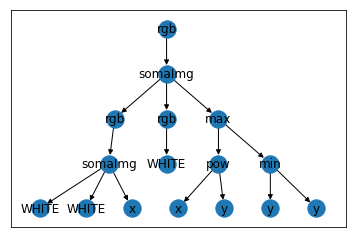

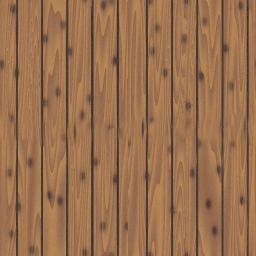

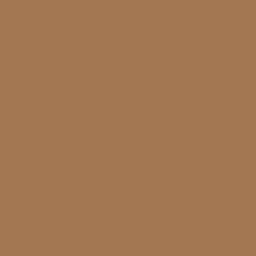

In [15]:
tree = gp.PrimitiveTree(hof[0])
compiledExpression = gp.compile(tree, pset)

print(hof[0])
plotTree(hof[0])
cv2_imshow(TARGET_IMG)
result = compiledExpression(20, 45)
cv2_imshow(result)
